# 1. Install Dependencies and Setup

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [18]:
import cv2
from PIL import Image

In [19]:
data_dir = 'data'

In [20]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [22]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# 3. Load Data

In [23]:
import numpy as np
from matplotlib import pyplot as plt

In [24]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [25]:
data_iterator = data.as_numpy_iterator()

In [26]:
batch = data_iterator.next()

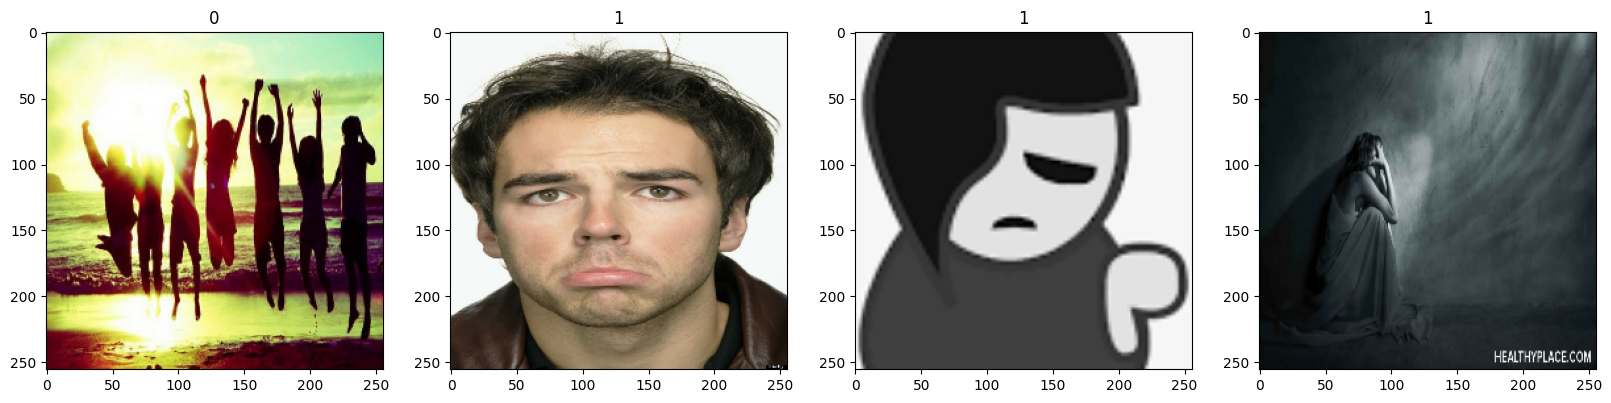

In [28]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [29]:
data = data.map(lambda x,y: (x/255, y))

In [30]:
data.as_numpy_iterator().next()

(array([[[[0.04313726, 0.03529412, 0.07843138],
          [0.04313726, 0.03529412, 0.07843138],
          [0.04313726, 0.03529412, 0.07843138],
          ...,
          [0.04705882, 0.05490196, 0.10588235],
          [0.04820652, 0.05604966, 0.10703006],
          [0.03888358, 0.04672672, 0.09770712]],
 
         [[0.04313726, 0.03529412, 0.07843138],
          [0.04313726, 0.03529412, 0.07843138],
          [0.03921569, 0.03137255, 0.07450981],
          ...,
          [0.04957108, 0.05741422, 0.11623774],
          [0.04545575, 0.05329889, 0.11212242],
          [0.04143689, 0.04928003, 0.10810355]],
 
         [[0.04313726, 0.03529412, 0.07843138],
          [0.04313726, 0.03529412, 0.07843138],
          [0.03921569, 0.03137255, 0.07450981],
          ...,
          [0.05098039, 0.05882353, 0.11764706],
          [0.06239181, 0.07023495, 0.12905848],
          [0.0640686 , 0.07191174, 0.13073526]],
 
         ...,
 
         [[0.03137255, 0.02352941, 0.06666667],
          [0.03137

# 5. Split Data

In [31]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [32]:
train_size

7

In [33]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [34]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [88]:
model = Sequential()

In [89]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [90]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [91]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [92]:
logdir='logs'

In [93]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [94]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5313 - loss: 1.2609 - val_accuracy: 0.5781 - val_loss: 0.7257
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5256 - loss: 0.7399 - val_accuracy: 0.5625 - val_loss: 0.6384
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6469 - loss: 0.6590 - val_accuracy: 0.7500 - val_loss: 0.5970
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7759 - loss: 0.5916 - val_accuracy: 0.8125 - val_loss: 0.4403
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7572 - loss: 0.4813 - val_accuracy: 0.7344 - val_loss: 0.4927
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7754 - loss: 0.4678 - val_accuracy: 0.9688 - val_loss: 0.3800
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8926 - loss: 0.3689 - val_accuracy: 0.9531 - val_loss: 0.2575
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8631 - loss: 0.3532 - val_accuracy: 0.8281 - val_loss: 0.3229
Epoch 9/

# 8. Plot Performance

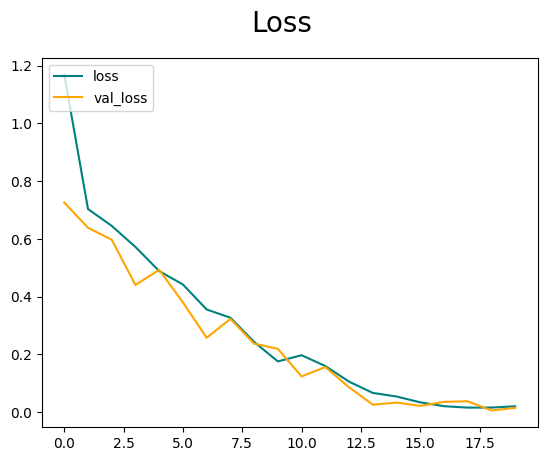

In [95]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

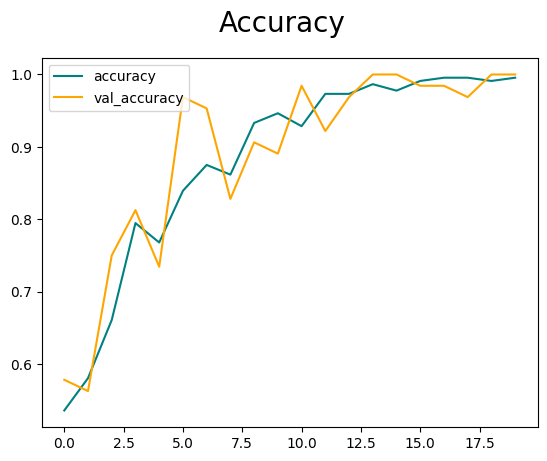

In [96]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [97]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [98]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [100]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


In [101]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9285714, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9705882, shape=(), dtype=float32)


# 10. Test

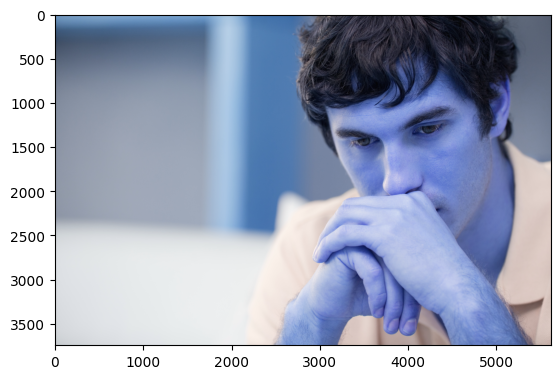

In [102]:
img = cv2.imread('sad.jpg')
plt.imshow(img)
plt.show()

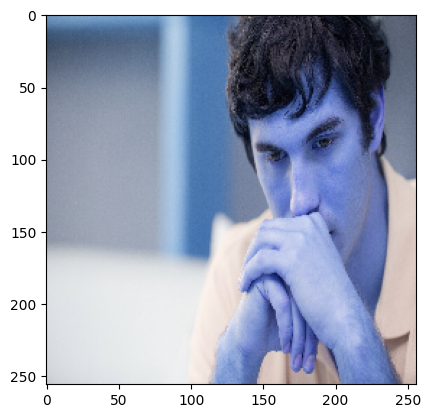

In [103]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [107]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [108]:
yhat

array([[0.99910766]], dtype=float32)

In [109]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


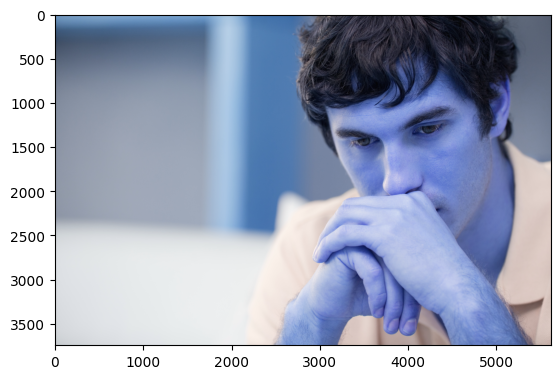

In [110]:
img = cv2.imread('sad.jpg')
plt.imshow(img)
plt.show()

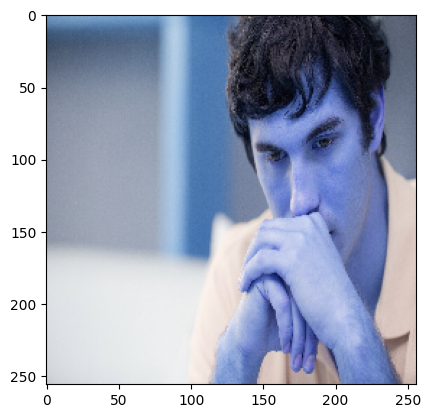

In [61]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [111]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [112]:
from tensorflow.keras.models import load_model

In [113]:
from keras.saving import save_model

In [114]:
new_model = load_model('models/imageclassifier.keras', compile=False)

In [115]:
prediction = new_model.predict(np.expand_dims(resize / 255.0, axis=0))
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
[[0.999342]]
